In [7]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

1. Extract the keypoints and descriptors from the first two images using the SIFT algorithm and draw them overlaid on the original images to visualize and verify their correctness.

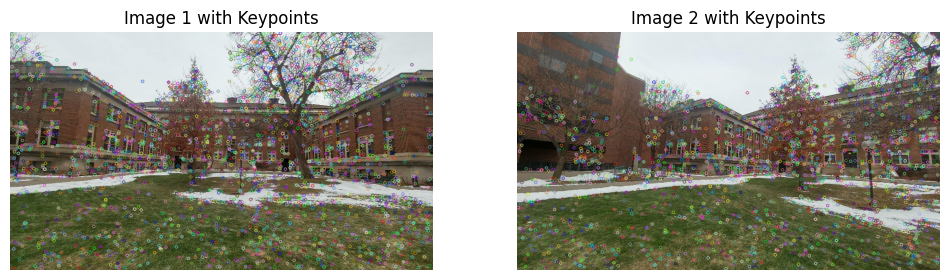

In [8]:
image1 = cv2.imread('panaroma_generation\\2.jpg') #train
image2 = cv2.imread('panaroma_generation\\1.jpg') #query
# plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))

#initialize SIFT detector
sift = cv2.SIFT_create()

#detect keypoints and compute descriptors
keypoints1, descriptors1 = sift.detectAndCompute(image1, None)
keypoints2, descriptors2 = sift.detectAndCompute(image2, None)

#visualize keypoints
image1_with_keypoints = cv2.drawKeypoints(image1, keypoints1, None)
image2_with_keypoints = cv2.drawKeypoints(image2, keypoints2, None)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image1_with_keypoints, cv2.COLOR_BGR2RGB))
plt.title('Image 1 with Keypoints')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image2_with_keypoints, cv2.COLOR_BGR2RGB))
plt.title('Image 2 with Keypoints')
plt.axis('off')

plt.show()


2. Match the extracted features using two different algorithms: BruteForce and FlannBased. After performing the matching, display the matched features by drawing lines between them.

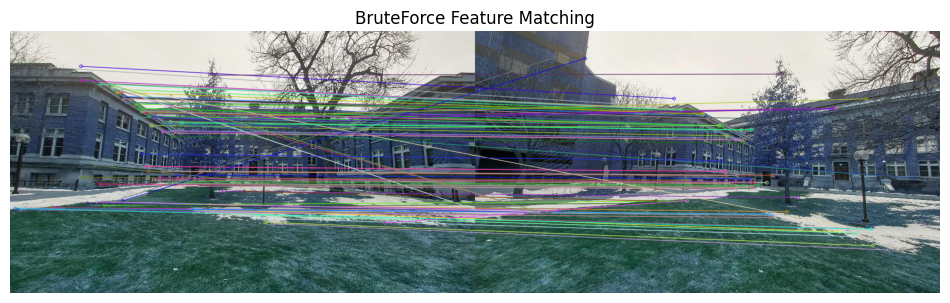

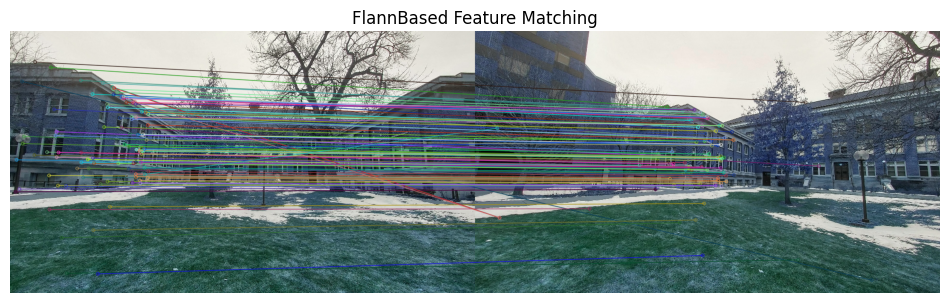

In [9]:
bf = cv2.BFMatcher()
#bruteForce
matches_bf = bf.match(descriptors1, descriptors2)

#sort matches
matches_bf = sorted(matches_bf, key=lambda x: x.distance)

#draw lines
image_matches_bf = cv2.drawMatches(image1, keypoints1, image2, keypoints2, matches_bf[:100], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(12, 6))
plt.imshow(image_matches_bf)
plt.title('BruteForce Feature Matching')
plt.axis('off')
plt.show()

flann = cv2.FlannBasedMatcher()
#flannBased
matches_flann = flann.knnMatch(descriptors1, descriptors2, k=2)

#ratio test to get only good matches
good_matches_flann = []
for m, n in matches_flann:
    if m.distance < 0.75 * n.distance:
        good_matches_flann.append(m)

#draw lines
image_matches_flann = cv2.drawMatches(image1, keypoints1, image2, keypoints2, good_matches_flann[:100], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(12, 6))
plt.imshow(image_matches_flann)
plt.title('FlannBased Feature Matching')
plt.axis('off')
plt.show()

3. Compute Homography matrix using RANSAC.

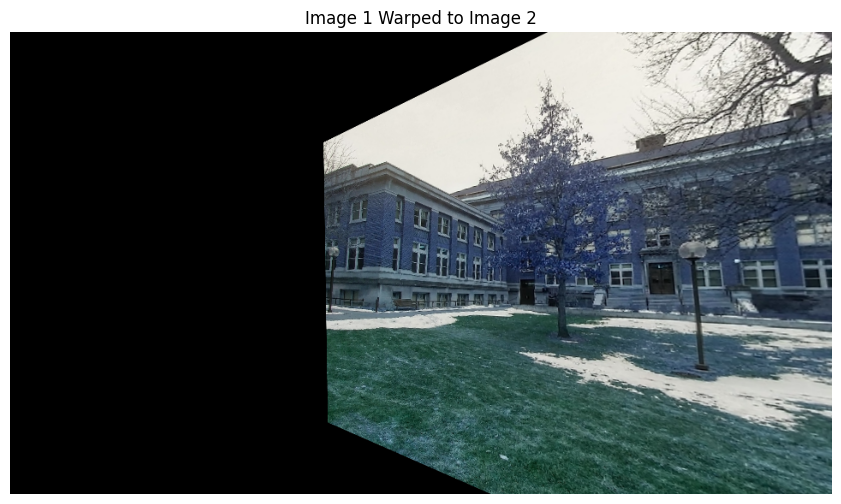

In [10]:
#RANSAC to compute homography matrix
homography, mask = cv2.findHomography(np.float32([keypoints1[m.queryIdx].pt for m in good_matches_flann]).reshape(-1,1,2),
                                       np.float32([keypoints2[m.trainIdx].pt for m in good_matches_flann]).reshape(-1,1,2),
                                       cv2.RANSAC, 5.0)

#warp image1 to image2 using computed homography
image1_warped = cv2.warpPerspective(image1, homography, (image2.shape[1], image2.shape[0]))

plt.figure(figsize=(12, 6))
plt.imshow(image1_warped, cmap='gray')
plt.title('Image 1 Warped to Image 2')
plt.axis('off')
plt.show()


In [11]:
print(homography)

[[-1.63891433e-02 -3.52143971e-02  3.65833825e+02]
 [-3.04538936e-01  5.51932558e-01  1.28653772e+02]
 [-1.01375766e-03 -1.20285389e-04  1.00000000e+00]]


4. Wrap the two images together using the homography matrix and display the left and right sides of the resulting panorama before cropping.

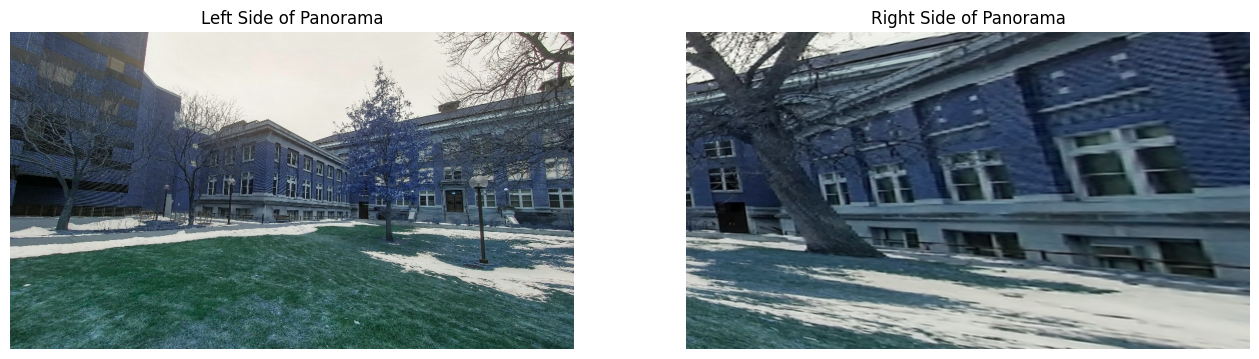

In [21]:
# Combine images into a single canvas
panorama_width = image2.shape[1] + image1.shape[1]
panorama_height = max(image2.shape[0], image1.shape[0])
panorama = np.zeros((panorama_height, panorama_width, 3), dtype=np.uint8)

# Warp image1 and paste onto panorama
image1_warped = cv2.warpPerspective(image1, homography, (panorama_width, panorama_height))
panorama[:image1_warped.shape[0], :image1_warped.shape[1]] = image1_warped

# Paste image2 onto panorama
panorama[:image2.shape[0],:image2.shape[1]] = image2

# Display left and right sides of the resulting panorama
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(panorama[:, :image1.shape[1]])
plt.title('Left Side of Panorama')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(panorama[:, image1.shape[1]:])
plt.title('Right Side of Panorama')
plt.axis('off')

plt.show()

5. Two images should be stitched together to form a panorama. Display the final panorama without any cropping or blending, along with the panorama after cropping and blending.

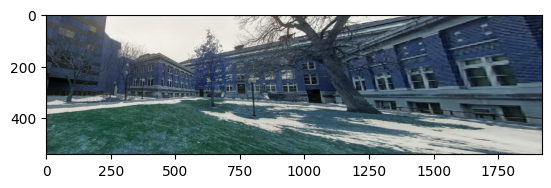

In [22]:
plt.imshow(panorama)
plt.show()

In [17]:
image1_warped.shape

(540, 1920, 3)

In [19]:
image2.shape

(540, 960, 3)

In [28]:
final_panorama = cv2.warpPerspective(image1, homography, (panorama_width, panorama_height))
final_panorama[:image2.shape[0], :image2.shape[1]] = image2


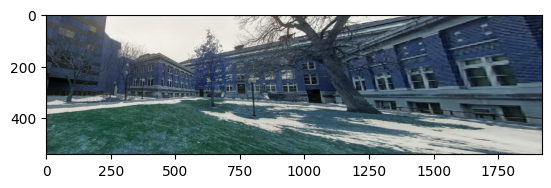

In [29]:
plt.imshow(final_panorama)
plt.show()

6. Perform multi stitching for all the images in the folder and display the final result.

In [4]:
image_paths = [f'panaroma_generation\\{i}.jpg' for i in range(1,9)] 
print(image_paths)
# panaroma_generation\\1.jpg

['panaroma_generation\\1.jpg', 'panaroma_generation\\2.jpg', 'panaroma_generation\\3.jpg', 'panaroma_generation\\4.jpg', 'panaroma_generation\\5.jpg', 'panaroma_generation\\6.jpg', 'panaroma_generation\\7.jpg', 'panaroma_generation\\8.jpg']


Panorama created successfully!


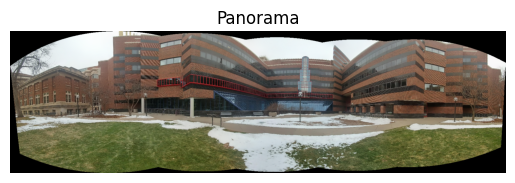

In [5]:
import cv2
import matplotlib.pyplot as plt

image_paths = [f'panaroma_generation\\{i}.jpg' for i in range(1,9)] 
images = [cv2.imread(path) for path in image_paths]

stitcher = cv2.Stitcher_create()

status, panorama = stitcher.stitch(images)

if status == cv2.Stitcher_OK:
    plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
    plt.title("Panorama")
    plt.axis('off')
    plt.show()
else:
    print("Stitching failed!")
